# ライトニングpytorch入門

- https://qiita.com/sh-tatsuno/items/42fccff90c98103dffc9
- https://github.com/sh-tatsuno/pytorch/tree/master/tutorials
- https://github.com/sh-tatsuno/pytorch/blob/master/tutorials/Pytorch_Tutorials.ipynb

In [9]:
import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々

import numpy as np

## Pytorchの基本

In [10]:
x = torch.Tensor(5, 3)
y = torch.rand(5, 3)
z = x + y

In [11]:
x, y, z

(tensor([[6.7333e+22, 1.7591e+22, 1.7184e+25],
         [4.3222e+27, 6.1972e-04, 7.2443e+22],
         [1.7728e+28, 7.0367e+22, 2.9926e+21],
         [4.1068e-08, 1.0538e-11, 2.0428e+20],
         [8.3895e-07, 8.1919e-10, 6.3011e-10]]),
 tensor([[0.2952, 0.2615, 0.9902],
         [0.1156, 0.9849, 0.5432],
         [0.5931, 0.8572, 0.8440],
         [0.1307, 0.0143, 0.3704],
         [0.3464, 0.2064, 0.4068]]),
 tensor([[6.7333e+22, 1.7591e+22, 1.7184e+25],
         [4.3222e+27, 9.8549e-01, 7.2443e+22],
         [1.7728e+28, 7.0367e+22, 2.9926e+21],
         [1.3068e-01, 1.4270e-02, 2.0428e+20],
         [3.4641e-01, 2.0638e-01, 4.0676e-01]]))

In [12]:
# 全ての変数はTensorに変換する必要がある
x = np.random.rand(5, 3)
y = torch.from_numpy(x)
z = y.numpy()

In [13]:
x, y, z

(array([[0.3629789 , 0.70929672, 0.7421238 ],
        [0.77249985, 0.76290581, 0.34722547],
        [0.03590953, 0.37297388, 0.98515573],
        [0.98219279, 0.70901926, 0.7469488 ],
        [0.99470361, 0.37431763, 0.08880553]]),
 tensor([[0.3630, 0.7093, 0.7421],
         [0.7725, 0.7629, 0.3472],
         [0.0359, 0.3730, 0.9852],
         [0.9822, 0.7090, 0.7469],
         [0.9947, 0.3743, 0.0888]], dtype=torch.float64),
 array([[0.3629789 , 0.70929672, 0.7421238 ],
        [0.77249985, 0.76290581, 0.34722547],
        [0.03590953, 0.37297388, 0.98515573],
        [0.98219279, 0.70901926, 0.7469488 ],
        [0.99470361, 0.37431763, 0.08880553]]))

### pytorchの自動微分機能
pytorchはautogradというTensorの自動微分機能を備えている.  
この機能はdefined-by-run形式で、どのようにコードが走ったかで微分方向が変わる.  
そのため、ループごとに構造を変えるなどの柔軟な記述もできる.

In [14]:
import torch
from torch.autograd import Variable

In [15]:
# Tensor型にしたものを微分対応させるためには Variable型にする必要がある
x = Variable(torch.ones(2, 2), requires_grad=True)
y = x + 2
z = torch.pow(y,2) + 2 #y_i**2 + 2
out = z.mean()

In [16]:
out.backward()

In [17]:
x.grad

tensor([[1.5000, 1.5000],
        [1.5000, 1.5000]])

↓ よくわからない例

In [18]:
x = torch.randn(3)
x = Variable(x, requires_grad=True)

y = x*2
while y.norm() < 1000:
    y = y*2

In [19]:
y.norm(), y

(tensor(1286.5626, grad_fn=<NormBackward0>),
 tensor([ -220.1311, -1220.3700,  -342.7576], grad_fn=<MulBackward0>))

In [20]:
gradients = torch.FloatTensor([0.1, 1.0, 0.0001])
y.backward(gradients)

In [21]:
x.grad

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])

### データの取得, 変換

In [22]:
# pytorchで与えるデータはTensor(train), Tensor(target)のようにする必要がある.
# データラベルを同時に変換させる関数としてTensorDatasetがある.
train_size = 10000
test_size = 1000
x_train, y_train = np.random.rand(train_size, 784), np.random.rand(train_size, 1)
x_test, y_test = np.random.rand(test_size, 784), np.random.rand(test_size, 1)

train = torch.utils.data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
train_loader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)
test = torch.utils.data.TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))
test_loader = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True)

## pytorchによるDNN入門

In [23]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

### モデルの構築

In [24]:
# networkの定義
# DNNの構造とrunの方法を定義する
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # 1つの入力チャネル, 6つの出力チャネル 5*5の畳み込み
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # 線形演算
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        
        # 2*2のwindowでmax pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) # スカラで与えると2*2になる
        
        # 型変換（reshape）
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
    def num_flat_features(self, x):
        # バッチの次元以外をflatにする
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [25]:
net = Net()
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [28]:
# パラメータの確認
params = list(net.parameters())
for param in params:
    # weight と bias？
    print(param.size())

torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


In [29]:
# 出力テスト
_input = Variable(torch.randn(1, 1, 32, 32))
out = net(_input)
out

tensor([[-0.1347, -0.0601, -0.0381,  0.0180,  0.0557,  0.0845, -0.1078, -0.0375,
          0.0637,  0.0449]], grad_fn=<AddmmBackward>)

In [30]:
#勾配を初期化
net.zero_grad()

In [31]:
# ランダムな勾配でback-propagation
out.backward(torch.randn(1, 10))

### Loss関数の定義

In [62]:
# input->net->output
output = net(_input)

# ダミーラベル情報
target = torch.Tensor(1, 10)

# loss関数の定義
criterion = nn.MSELoss()

# どの部分でlossを比較するか
loss = criterion(output, target)

In [63]:
output, target

(tensor([[-0.1247, -0.0466, -0.0182,  0.0197,  0.0707,  0.0977, -0.0953, -0.0322,
           0.0821,  0.0622]], grad_fn=<AddmmBackward>),
 tensor([[ 1.6515e-12,  4.5594e-41,  1.1433e-36,  0.0000e+00, -4.1856e-14,
           4.5593e-41,  1.1807e-36,  0.0000e+00,  1.2122e-36,  0.0000e+00]]))

In [64]:
loss

tensor(0.0054, grad_fn=<MseLossBackward>)

In [65]:
# creator
loss.grad_fn

## Backpropagation

In [66]:
# 勾配を初期化
net.zero_grad()

# backpropagation前
print('before conv1.bias.grad')
print(net.conv1.bias.grad)

loss.backward()

# backpropagation後
print('after conv1.bias.grad')
print(net.conv1.bias.grad)

before conv1.bias.grad
tensor([0., 0., 0., 0., 0., 0.])
after conv1.bias.grad
tensor([ 5.6312e-04, -7.0789e-05, -7.1685e-05,  5.3128e-05,  3.6053e-04,
        -3.3237e-04])


## 重み更新

更新関数は自作することも可能

In [45]:
learning_rate = 0.01
for f in net.parameters():
    # weight = weight - learning_rate * gradient
    f.data.sub_(f.grad.data * learning_rate)

`torch.optim`に最適化関数のパッケージがある

In [67]:
import torch.optim as optim

# 最適化関数のインスタンス化
# ネットワークの重みや勾配情報の generator を入力する
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# --- 学習の 1 loop ---
# 1. 最適化関数の初期化
optimizer.zero_grad()
# 2. モデルから出力を取得
output = net(_input)
# 3. lossの計算, backpropagation → 勾配情報がモデルに保存される
loss = criterion(output, target)
loss.backward()
# 4. 重み更新
optimizer.step()

# pytorchを使った画像分類入門

CIFAR-10のデータセットでCNNで分類してみる

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# https://github.com/lanpa/tensorboardX
from tensorboardX import SummaryWriter

## CIFAR10のデータロード

In [3]:
rawtrainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

Files already downloaded and verified


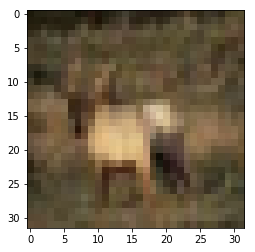

In [4]:
img = rawtrainset[3][0]
_ = plt.imshow(img)

In [5]:
# 32*32*3channel
img_array = np.array(img)
img_array.shape

(32, 32, 3)

## Normialize
正規化。-1~1に変換

In [6]:
# transform: PIL Image変形用のモジュール
# Tensorに変形してRGBの各チャネルに対して平均0.5, 分散0.5に標準化
transform = transforms.Compose(
    [transforms.ToTensor(), # 0~1の範囲でテンソル化
     # transforms.Normalize(mean,std)はchannel = (channel - mean) / stdの変換を行う
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # -1~1に正規化

#CIFAR-10のtrain, testsetのロード
#変形はtransformを適用
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoarder の適用 バッチ学習やシャッフルとかをしてくれる
# batch_sizeでバッチサイズ指定
# num_workersでデータをロードするコア数指定
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

# ラベルとクラスの対応
class_list = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# transforms.ToTensor()(rawtrainset[0][0])

In [8]:
# trainset[0][0]

In [9]:
_train_sample = iter(train_loader).next()
# [[x1, x2, ..], [y1, y2, ..]] で入る
len(_train_sample[0]) # バッチサイズ 4

4

## 画像の描画

In [10]:
def imshow(img):
    img = img*0.5 + 0.5 # 標準化した画像を元の値に変換
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [11]:
# 4個分の画像とラベルの読み込み
dataiter = iter(train_loader)
images, labels = dataiter.next()

['deer', 'plane', 'horse', 'frog']


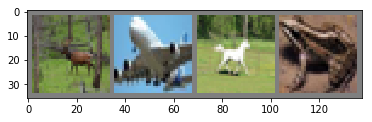

In [12]:
# 画像を繋げて描画
imshow(torchvision.utils.make_grid(images))
print([class_list[l] for l in labels])

In [13]:
images.size()

torch.Size([4, 3, 32, 32])

## モデル構築

In [30]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # x: (3, 32, 32)
        
        x = F.relu(self.conv1(x)) # (6, 28, 28)
        x = self.pool(x) # (6, 14, 14)
        x = F.relu(self.conv2(x)) # (16, 10, 10)
        x = self.pool(x) # (16, 5, 5)
        x = x.view(-1, 16*5*5) # (16*5*5)
        x = F.relu(self.fc1(x)) # (120)
        x = F.relu(self.fc2(x)) # (84)
        x = self.fc3(x) # (10)
        return x

In [26]:
def try_gpu(e):
    if torch.cuda.is_available():
        return e.cuda()
    return e

In [27]:
net = Net()
net = try_gpu(net)

In [32]:
# tensorboard
dummy_input = torch.Tensor(4, 3, 32, 32)
with SummaryWriter('logs', comment='CNN') as w:
    w.add_graph(net, try_gpu(dummy_input))

## Loss, Optimizer

In [33]:
import torch.optim as optim
# Loss関数の指定
criterion = nn.CrossEntropyLoss()
# Optimizerの指定
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 学習

In [36]:
writer = SummaryWriter('logs')

for epoch in range(2):
    
    running_loss = 0.0
    
    for i, (inputs, labels) in enumerate(train_loader):
        
        # 入力データ-ラベル
        inputs, labels = try_gpu(inputs), try_gpu(labels)
        
        # Variableに変形
        inputs, labels = Variable(inputs), Variable(labels)
        
        # optimizerの初期化
        optimizer.zero_grad()
        
        # 出力
        outputs = net(inputs)
        # loss, backpropagation, optim
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # log
        writer.add_scalar('train/loss', loss.data.item(), i*(epoch+1))
        running_loss += loss.data.item()
        
        if i%1000==999:
            print(f'step{i*(epoch+1)+1} loss:{running_loss/2000}')
            running_loss = 0

print('Finished Train')

step1000 loss:0.772508755505085
step2000 loss:0.7585824604332447
step3000 loss:0.7484842498898506
step4000 loss:0.7366381895840168
step5000 loss:0.7343597276061773
step6000 loss:0.7195540308058261
step7000 loss:0.7009999278783798
step8000 loss:0.709689303740859
step9000 loss:0.6828709129691124
step10000 loss:0.6925980863273143
step11000 loss:0.6667536693364382
step12000 loss:0.6784817864745856
step1999 loss:0.6262766677588224
step3999 loss:0.6307439768016339
step5999 loss:0.6189034359306097
step7999 loss:0.6174442539066076
step9999 loss:0.6131589267700911
step11999 loss:0.6238273134231568
step13999 loss:0.6245198415517808
step15999 loss:0.6130777754634619
step17999 loss:0.606252468124032
step19999 loss:0.611197123631835
step21999 loss:0.612439124032855
step23999 loss:0.5931224361509084
Finished Train


# テスト

GroundTruth: ['truck', 'bird', 'cat', 'frog']


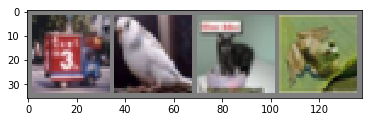

In [37]:
#テストについても同様に4つサンプリングする
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(f'GroundTruth: {[class_list[l] for l in labels]}')

In [40]:
#画像をネットワークに通す
outputs = net(try_gpu(Variable(images)))

In [41]:
outputs

tensor([[-1.4864,  0.6234, -0.4182,  0.1694, -1.0610,  1.3362, -0.6563,  0.6723,
         -0.3832,  2.7878],
        [-2.8284, -1.2293,  0.8099,  3.8233, -3.0522,  3.3824, -0.9304,  0.5230,
         -0.2092,  0.0221],
        [ 0.3066, -1.8927,  0.9076,  1.2753,  0.2400, -0.0189,  1.9547, -1.5381,
         -0.2295, -1.1897],
        [ 1.1872, -0.8648,  2.6230, -1.1463,  0.4303, -2.1760,  3.1375, -3.1347,
          0.8564, -1.9475]], device='cuda:0', grad_fn=<AddmmBackward>)

In [42]:
# predictの最大を計測する
[class_list[i] for i in outputs.max(1)[1]]

['truck', 'cat', 'frog', 'frog']

In [43]:
labels.size()

torch.Size([4])

In [46]:
# Accuracy
correct = 0
total = 0
for images, labels in test_loader:
    images, labels = try_gpu(images), try_gpu(labels)
    outputs = net(Variable(images))
    _, predicts = outputs.max(1)
    total += labels.size(0)
    correct += (predicts == labels).sum()
    
print(f'Accuracy test: {correct}/{total}')

Accuracy test: 5719/10000


In [49]:
# Accuracy by class
class_correct = [0 for _ in range(10)]
class_total = [0 for _ in range(10)]

for images, labels in test_loader:
    images, labels = try_gpu(images), try_gpu(labels)
    outputs = net(Variable(images))
    _, predicts = outputs.max(1)
    correct_list = (predicts == labels).squeeze()
    for i, label in enumerate(labels):
        class_correct[label] += correct_list[i]
        class_total[label] += 1
        print(f'\r{i}', end='')
        
for i in range(10):
    print(f'Accuracy of {class_list[i]}: {100*class_correct[i]/class_total[i]}%')

3Accuracy of plane: 49%
Accuracy of car: 63%
Accuracy of bird: 64%
Accuracy of cat: 31%
Accuracy of deer: 37%
Accuracy of dog: 35%
Accuracy of frog: 69%
Accuracy of horse: 65%
Accuracy of ship: 80%
Accuracy of truck: 75%
